In [1]:
import pandas as pd
import gensim
import nltk 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,LSTM,GRU,Dense
from keras.utils import to_categorical
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

dataset = pd.read_csv("Emotion_final.csv")
fichier_test = open('test.txt','r')

#On transforme le fichier test en dataframe 
#et on remplace 'joy' par 'happy' pour que ça colle avec le fichier d'entrainement

colonne_texte_test = []
colonne_emotions_test = []

for i in fichier_test:
    ligne = i.split(';')
    colonne_emotions_test.append(ligne[1].strip())
    colonne_texte_test.append(ligne[0])

for i in range(len(colonne_emotions_test)):
    if colonne_emotions_test[i] == 'joy':
        colonne_emotions_test[i] = 'happy'


dataset_test = pd.DataFrame({'Text':colonne_texte_test,'Emotion':colonne_emotions_test})

dataset = dataset.dropna()
dataset_test = dataset_test.dropna()

Using TensorFlow backend.
C:\Users\quent\anaconda3\envs\testenv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\quent\anaconda3\envs\testenv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\quent\anaconda3\envs\testenv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\quent\anaconda3\envs\testenv\lib

In [2]:
colonne_emotions = dataset['Emotion']
colonne_texte = dataset['Text']
colonne_texte2 = pd.DataFrame(dataset['Text'])
colonne_emotions_test = dataset_test['Emotion']
colonne_texte_test = dataset_test['Text']

In [3]:
ps = nltk.stem.porter.PorterStemmer()
corpus = []
max_len = 0

#Dans cette boucle on va raciniser/stemmer tous les messages.
#On calcule aussi la nombre de mots dans le plus long message.

for i in colonne_texte:
    nouvelle_ligne = i.lower().split()
    nouvelle_ligne = [ps.stem(j) for j in nouvelle_ligne if not j in nltk.corpus.stopwords.words('english')]
    if len(nouvelle_ligne)>max_len:
        max_len = len(nouvelle_ligne)
    nouvelle_ligne = ' '.join(nouvelle_ligne)
    corpus.append(nouvelle_ligne)
    
print(max_len)

35


In [4]:
ps_test = nltk.stem.porter.PorterStemmer()
corpus_test = []
max_len_test = 0

#Dans cette boucle on va raciniser/stemmer tous les messages.
#On calcule aussi la nombre de mots dans le plus long message.

for i in colonne_texte_test:
    nouvelle_ligne = i.lower().split()
    nouvelle_ligne = [ps.stem(j) for j in nouvelle_ligne if not j in nltk.corpus.stopwords.words('english')]
    if len(nouvelle_ligne)>max_len_test:
        max_len_test = len(nouvelle_ligne)
    nouvelle_ligne = ' '.join(nouvelle_ligne)
    corpus_test.append(nouvelle_ligne)
    
print(max_len_test)

31


In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus+corpus_test)
index_mots = tokenizer.word_index
taille_vocabulaire = len(index_mots) + 1

In [26]:
#On transforme les echantillons de text en vecteur tokenisés

sequence = tokenizer.texts_to_sequences(corpus)
sequence_test = tokenizer.texts_to_sequences(corpus_test)

In [7]:
#On met tous les vecteurs à la même taille

max_len = max(max_len,max_len_test)

pad_corpus = pad_sequences(sequence, maxlen = max_len)
pad_corpus_test = pad_sequences(sequence_test, maxlen = max_len)

In [8]:
#On donne une valeur numérique aux émotions qui deviennent donc des classes

dictionnaire_emotions = {'sadness':0,'anger':1,'love':2,'surprise':3,'fear':4,'happy':5}

emotions = [dictionnaire_emotions[x] for x in dataset['Emotion']]
emotions =to_categorical(emotions)
emotions_test = [dictionnaire_emotions[x] for x  in dataset_test['Emotion']]
emotions_test = to_categorical(emotions_test)

In [9]:
#On crée le modèle à trois couches

taille_output = int(taille_vocabulaire/100)

model = Sequential()

model.add(Embedding(taille_vocabulaire, taille_output, input_length = max_len))

model.add(Bidirectional(GRU(units=taille_output,dropout=0.2,recurrent_dropout=0.2)))

model.add(Dense(len(dictionnaire_emotions), activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 131)           1727890   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 262)               206718    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1578      
Total params: 1,936,186
Trainable params: 1,936,186
Non-trainable params: 0
_________________________________________________________________


In [10]:
#On entraîne le modèle

history = model.fit(pad_corpus, emotions, batch_size = 131, epochs = 8, validation_data = (pad_corpus_test, emotions_test))


Train on 21459 samples, validate on 2000 samples
Epoch 1/8
21459/21459 [==============================] - 33s 2ms/step - loss: 1.1708 - accuracy: 0.5697 - val_loss: 0.5869 - val_accuracy: 0.8240
Epoch 2/8
21459/21459 [==============================] - 31s 1ms/step - loss: 0.3683 - accuracy: 0.8838 - val_loss: 0.3423 - val_accuracy: 0.8960
Epoch 3/8
21459/21459 [==============================] - 30s 1ms/step - loss: 0.1993 - accuracy: 0.9332 - val_loss: 0.2988 - val_accuracy: 0.9010
Epoch 4/8
21459/21459 [==============================] - 31s 1ms/step - loss: 0.1499 - accuracy: 0.9490 - val_loss: 0.2267 - val_accuracy: 0.9275
Epoch 5/8
21459/21459 [==============================] - 33s 2ms/step - loss: 0.1267 - accuracy: 0.9584 - val_loss: 0.2276 - val_accuracy: 0.9200
Epoch 6/8
21459/21459 [==============================] - 31s 1ms/step - loss: 0.1094 - accuracy: 0.9598 - val_loss: 0.2018 - val_accuracy: 0.9295
Epoch 7/8
21459/21459 [==============================] - 33s 2ms/step - lo

In [28]:
#Une fonction qui renvoie le sentiment prédit par le modèle 
#un exemple de forme de phrase à rentrer est fait dessous

import numpy as np
classes = list(dictionnaire_emotions.keys())

def testEmotion(message):
    
    new_sequence = tokenizer.texts_to_sequences(message)
    new_sequence_padded = pad_sequences(new_sequence, maxlen = max_len)
    prediction = model. predict(new_sequence_padded)
    print("Votre message : " + str(message) + "\n")
    print("Votre emotion : " ,classes[np.argmax(prediction)] )
    
testEmotion(['im feeling rather rotten so im not very ambitious right now'])

Votre message : ['im feeling rather rotten so im not very ambitious right now']

Votre emotion :  sadness


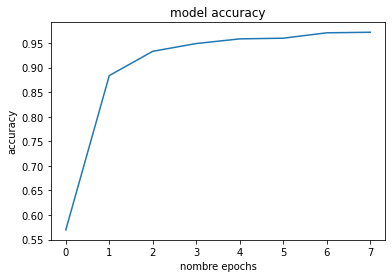

AxesSubplot(0.125,0.125;0.62x0.755)

 Accuracy :0.928
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       581
           1       0.92      0.93      0.93       275
           2       0.81      0.89      0.85       159
           3       0.78      0.80      0.79        66
           4       0.93      0.89      0.91       224
           5       0.94      0.96      0.95       695

    accuracy                           0.93      2000
   macro avg       0.89      0.90      0.90      2000
weighted avg       0.93      0.93      0.93      2000



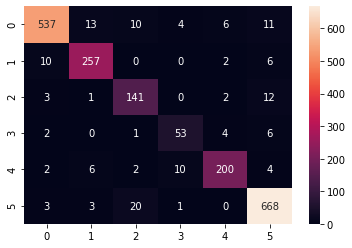

In [24]:
import matplotlib.pyplot as plt

#Métriques avec dans l'ordre l'accuracy/nombre d'epochs, une heatmap de la matrice de confusion,
#l'accuracy pour 8 epochs, le rapport de classification avec le F1 score
#on rapelle que les classes sont {'sadness':0,'anger':1,'love':2,'surprise':3,'fear':4,'happy':5}
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('nombre epochs')
plt.show()


emotions_tests_desencode = np.argmax(emotions_test, axis = 1)
emotions_predictions = model.predict_classes(pad_corpus_test)
print(sns.heatmap(confusion_matrix(emotions_tests_desencode, emotions_predictions),annot=True,fmt="d"))
print("\n Accuracy :" + str(accuracy_score(emotions_tests_desencode, emotions_predictions)))
print(classification_report(emotions_tests_desencode, emotions_predictions))